# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Загрузим данные. Выясним, сколько в них спам- и не спам-писем. Визуализируем соотношение.

In [1]:
import pandas as pd


email_data = pd.read_csv('data/spam_or_not_spam.csv')
display(email_data.shape)
email_data.head()


(3000, 2)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [2]:
# соотношение класса 0 (не спам) и класса 1 (спам)
email_data['label'].value_counts()


label
0    2500
1     500
Name: count, dtype: int64

In [3]:
import plotly.graph_objs as go


# процентное соотношение спама и не спама (1 - спам)
ratio = pd.DataFrame({'type': ['ham', 'spam'],
                      'value': round(email_data['label'].value_counts()/email_data.shape[0]*100, 2)
                      })

fig = go.Figure(go.Pie(labels=ratio['type'], values=ratio['value']))

fig.update_layout(title='Percentage ratio of ham and spam', title_x = 0.5, title_font_size=25,
                  showlegend=False)

fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=24,
                  hoverinfo='none',
                  marker=dict(colors=['#007dff', '#e75300']))

fig.show()


## Задание 2 (2 балла)

Предобработаем данные и переведем их в векторный вид. 

In [4]:
# подгрузим необходимый модуль:
from sklearn.feature_extraction.text import CountVectorizer


Заменим все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). Удалим все строки, в которых наблюдаются пропущенные значения.

In [5]:
import numpy as np

# всем строкам, состоящим из пробелов присвоим значение nan
email_data['email'] = email_data['email'].apply(lambda x: np.nan if str(x).isspace() else x)
# всем пустым строкам присвоим значение nan
email_data['email'] = email_data['email'].apply(lambda x: np.nan if str(x) == '' else x)
# удалим все строки с значениями nan
email_data.dropna(subset=['email', 'label'], inplace=True)
# проверим размерность
email_data.shape


(2997, 2)

Переведем данные в векторный вид:

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(email_data["email"]) # признаки


Проверим размерность:

In [7]:
X.shape


(2997, 34116)

## Задание 3 (2 балла)

Определим целевую переменную:

In [8]:
# целевая переменная
y = email_data['label']
# ее размерность
y.shape


(2997,)

Разделим выборку на обучающую и тестовую, используя стратифицированное разбиение, с размером тестовой выборки 0.25, параметр `random_state`: 42.

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
    )


Рассчитаем среднее значение целевой переменной по тестовой выборке (проверим сохранение баланса классов):

In [10]:
#  среднее значение по тестовой выборке
# с точность 3 знака после запятой
round(y_test.mean(), 3)


0.165

## Задание 4 (3 балла)

Определим и обучим Классификатор Байеса с комплементарной наивностью с параметром alpha = 0.01

In [11]:
from sklearn.naive_bayes import ComplementNB


# создаем объект класса ComplementNB (модель)
clf = ComplementNB(alpha=0.01)
# обучаем модель на тренировочной выборке
clf.fit(X_train, y_train)
# делаем предсказание на тестовой выборке
y_pred = clf.predict(X_test)


Оценим результат по трем метрикам:

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print(f'Метрика accuracy: {round(accuracy_score(y_test, y_pred), 3)}')
print(f'Метрика precision: {round(precision_score(y_test, y_pred), 3)}')
print(f'Метрика recall: {round(recall_score(y_test, y_pred), 3)}')
print(f'Метрика f1: {round(f1_score(y_test, y_pred), 3)}')


Метрика accuracy: 0.988
Метрика precision: 1.0
Метрика recall: 0.927
Метрика f1: 0.962


Нарисуем ROC-кривую:

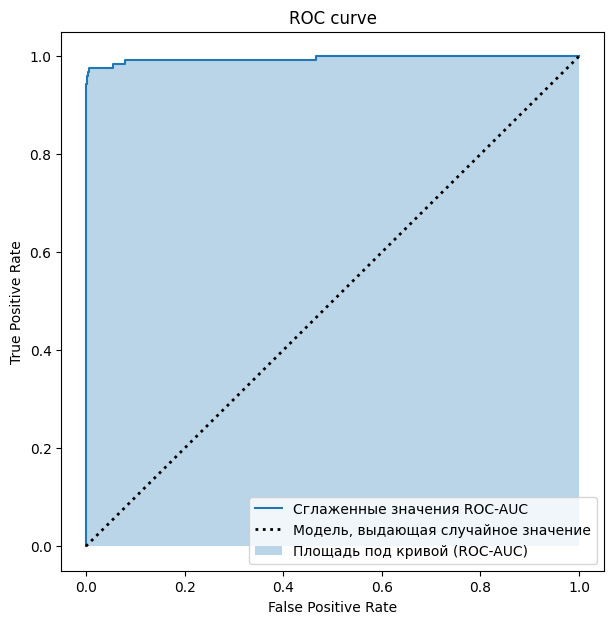

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


# оценки вероятности принадлежности к классу 0 (не спам) и 1 (спам)
# для каждого элемента целевой переменной, т.е для каждого эл. письма
pred_proba = clf.predict_proba(X_test)
# возьмем только вероятности принадлежности к классу 1 (спам)
pred_proba_1 = pred_proba[:, 1]

# определяем точки для ROC-кривой
false_positive_rates, true_positive_rates, _ = roc_curve(y_test, pred_proba_1)

# создаём график
plt.figure(figsize=(7, 7))
# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates,
         label='Сглаженные значения ROC-AUC')
# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':',
         label='Модель, выдающая случайное значение')
# название графика и осей
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# заполняем площадь под кривой
plt.fill_between(false_positive_rates, true_positive_rates,
                 alpha=0.3, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()


## Задание 5 (3 балла)

Переберем значения alpha с помощью кросс-валидации. Оценим, зависит ли от этого параметра качество классификации.

In [14]:
from sklearn.model_selection import GridSearchCV


# зададим массив значений для гиперпараметра alpha
# (от 0.001 до 1 с шагом 0.001)
param_grid = {'alpha': [i*0.001 for i in range(1, 1000)]}
# определим модель
model = ComplementNB()
# инициализируем объект GridSearchCV
grid_search = GridSearchCV(
    estimator=model, # используемая модель
    param_grid=param_grid, # параметры (гиперпараметр alpha)
    cv=5, # количество фолдов для кросс-валидации
    n_jobs = -1 # загрузка ядер процессора (все)
)

# подберем лучший гиперпараметр на тренировочной выборке
%time grid_search.fit(X_train, y_train)
# сделаем предсказание с лучшим гиперпараметром на тестовой выборке
y_pred = grid_search.predict(X_test)
# вычислим метрику f1 и выведем лучший гиперпараметр
print(f'f1_score на тестовом наборе: {round(f1_score(y_test, y_pred), 5)}')
print(f'Наилучшее значение гиперпараметра alpha: {grid_search.best_params_}')


CPU times: total: 3.09 s
Wall time: 11.9 s
f1_score на тестовом наборе: 0.98374
Наилучшее значение гиперпараметра alpha: {'alpha': 0.332}


Качество классификации зависит от гиперпараметра alpha. Наилучшее значение метрики f1: 0.98374 достигается при alpha = 0.332.